In [84]:
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.patches import Ellipse
from scipy.interpolate import interp1d
import pycbc
import pycbc.waveform as wf
from pycbc.detector import Detector
import lalsimulation as lalsim
import lal
#import bilby
from collections import defaultdict
import emcee
import time
import corner

In [85]:
class PSD:
    def __init__(self, psd_filename, prepend_points = [], append_points = []):
        self.f_vals, self.psd_vals = np.loadtxt(psd_filename, unpack = True)
        self.prepend_points = prepend_points
        self.append_points = append_points

        for point in self.prepend_points:
            self.f_vals = np.concatenate([np.array([point[0]]), self.f_vals])
            self.psd_vals = np.concatenate([np.array([point[1]]), self.psd_vals])

        for point in self.append_points:
            self.f_vals = np.concatenate([self.f_vals, np.array([point[0]])])
            self.psd_vals = np.concatenate([self.psd_vals, np.array([point[1]])])

        self.psd = interp1d(self.f_vals, self.psd_vals)

In [86]:
ligo_H1_psd = '/home/mukesh/Academics/EW3/data/GW170814/H1_PSD_GW170814.txt'
ligo_L1_psd = '/home/mukesh/Academics/EW3/data/GW170814/L1_PSD_GW170814.txt'
V1_psd = '/home/mukesh/Academics/EW3/data/GW170814/V1_PSD_GW170814.txt'

H1_psd_int = PSD(ligo_H1_psd)
L1_psd_int = PSD(ligo_L1_psd)
V1_psd_int = PSD(V1_psd)

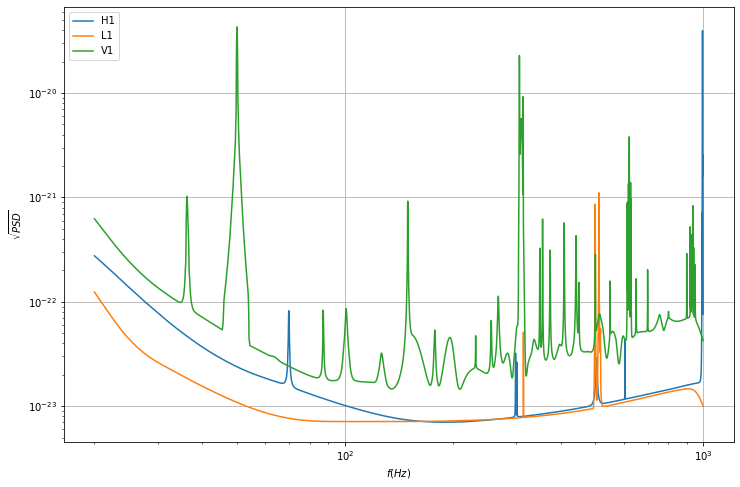

In [87]:
freq = np.linspace(20, 1000, 10000)
plt.figure(figsize=(12,8))
plt.loglog(freq, np.sqrt(H1_psd_int.psd(freq)), label='H1')
plt.loglog(freq, np.sqrt(L1_psd_int.psd(freq)), label='L1')
plt.loglog(freq, np.sqrt(V1_psd_int.psd(freq)), label='V1')
plt.xlabel('$f(Hz)$')
plt.ylabel('$\sqrt{PSD}$')
plt.legend(loc='best')
plt.grid()

In [5]:
def spher_harms_plus_cross_factors(inclination, phi0, l, m):
    
    d_lm = lal.SpinWeightedSphericalHarmonic(inclination, 0, -2, l, m).real
    d_lminusm = lal.SpinWeightedSphericalHarmonic(inclination, 0, -2, l, -m).real
    Y_lm = lal.SpinWeightedSphericalHarmonic(inclination, phi0, -2, l, m).real
    
    #Notations as deifined in the notes
    C_lm = (((-1)**l)*(d_lminusm/d_lm) + 1)*Y_lm
    D_lm = (((-1)**l)*(d_lminusm/d_lm) - 1)*Y_lm
    
    return C_lm, D_lm

In [6]:
def waveform_lm_mode(fmin, fmax, df, mode, m1, m2, inclination, distance, coa_phase, approx):
    
    mode_array_dict = {
        "22": [[2, 2], [2, -2]],
        "32": [[3, 2], [3, -2]],
        "21": [[2, 1], [2, -1]],
        "44": [[4, 4], [4, -4]],
        "33": [[3, 3], [3, -3]],
        "43": [[4, 3], [4, -3]],
        #"2244": [[2, 2], [4, 4], [4, -4]],
        #"2233": [[2, 2], [3, 3], [3, -3]],
    }
    
    hp, hc = wf.get_fd_waveform(approximant= approx,
                                mass1 = m1, 
                                mass2 = m2, 
                                inclination= inclination,
                                distance = distance,
                                f_lower = fmin,
                                f_final = fmax,
                                delta_f = df,
                                mode_array = mode_array_dict[mode],
                                coa_phase = coa_phase)
    
    # remove the angular dependence through dividing by spherical harmonics
    # so that we have to evaluate instrinsic part only once
    l = int(mode[0])
    m = int(mode[1])
    C_lm, D_lm = spher_harms_plus_cross_factors(inclination, 0.0, l, m)
    freq = hp.sample_frequencies.data
    hp = hp.data/C_lm
    hc = hc.data/(-1j*D_lm)
    h_intrinsic = hp
    return freq, h_intrinsic #, hp*C_lm

In [14]:
f, h_int = waveform_lm_mode(f_min, f_max, df, "22", mle["m1"], mle["m2"], mle["theta_jn"], mle["distance"], np.pi/4, "IMRPhenomXPHM")

In [15]:
#wf.fd_approximants()
C_lm, D_lm = spher_harms_plus_cross_factors(mle["theta_jn"], 0.0, 2, 2)
C_lm

0.47308734787878

(10, 2362.5740127065346)

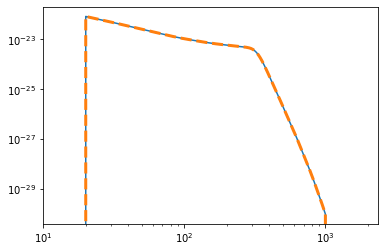

In [83]:
plt.loglog(f, abs(h_int))
plt.loglog(f, abs(hp_data/C_lm), ls='--', lw=3)
plt.xlim(10,)

In [7]:
def antenna_pattern_eff(ra, dec, pol, gps_time, det):
    # We can calcualate the antenna pattern for Hanford at
    # the specific sky location
    d = Detector(det)

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, gps_time)
    #print("fp={}, fc={}".format(fp, fc))
    f_mod = np.sqrt(fp**2 + fc**2)
    
    if det == "H1":
        kappa = np.arccos(fp/f_mod) - np.pi/2
    else:
        kappa = np.arccos(fp/f_mod)
    
    return kappa, f_mod

In [51]:
np.array(antenna_pattern_eff(mle["ra"], mle["dec"], mle["psi"], mle["geocent_time"], "H1"))*180/np.pi

array([32.25646347, 29.21013981])

In [52]:
np.array(antenna_pattern_eff(mle["ra"], mle["dec"], mle["psi"], mle["geocent_time"], "L1"))*180/np.pi

array([35.5088321 , 29.68266509])

In [53]:
np.array(antenna_pattern_eff(mle["ra"], mle["dec"], mle["psi"], mle["geocent_time"], "V1"))*180/np.pi

array([19.14775504, 26.76801184])

### Signal estimated as template evaluated at MLEs:

In [47]:
# ML estimates for GW170814
mle = dict()
mle["ra"] = 47.75*np.pi/180
mle["dec"] = -np.pi/4
#mle["kappa"] = np.pi/4.
mle["psi"] = np.pi/3.
mle["m1"] = 30.6
mle["m2"] = 25.2
mle["theta_jn"] = np.pi/4
mle["coa_phase"] = np.pi/4
mle["distance"] = 600.
mle["approx"] = "IMRPhenomXPHM"
mle["geocent_time"] = 1186741861.0
modes = ["22", "33", "44"]

In [48]:
h_intrinsic = {}
signal = {}
f_min = 20.
f_max = 1000.
df = 0.01
detectors = ["H1", "L1", "V1"]
for det in detectors:
    signal[det] = 0.0
    kappa, f_mod = antenna_pattern_eff(mle["ra"], mle["dec"], mle["psi"], mle["geocent_time"], det)
    for mode in modes:
        h_intrinsic[mode] = 0.0
        f, h_intrinsic[mode] = waveform_lm_mode(f_min, f_max, df, mode, mle["m1"], mle["m2"], mle["theta_jn"], mle["distance"], mle["coa_phase"], mle["approx"])
        l = int(mode[0])
        m = int(mode[1])
        lower_index = f >= f_min
        f = f[lower_index]
        h_intrinsic[mode] = h_intrinsic[mode][lower_index]
    
        upper_index = f <= f_max
        f = f[upper_index]
        h_intrinsic[mode] = h_intrinsic[mode][upper_index]
    
        C_lm, D_lm = spher_harms_plus_cross_factors(mle["theta_jn"], 0.0, l, m)
        signal[det] += (C_lm*np.cos(kappa) -1j*D_lm*np.sin(kappa))*h_intrinsic[mode]
    signal[det] = signal[det]*f_mod

In [49]:
signal

{'H1': array([-1.31686451e-23-1.40713238e-23j, -1.21766988e-23-1.49287316e-23j,
        -1.11167287e-23-1.56858494e-23j, ...,
        -7.33638309e-31+9.45166961e-31j, -7.33255596e-31+9.45060454e-31j,
         0.00000000e+00+0.00000000e+00j]),
 'L1': array([-7.45954081e-24+1.91704113e-23j, -8.74271101e-24+1.86118130e-23j,
        -9.96078566e-24+1.79414409e-23j, ...,
         1.24833352e-30+2.69500346e-31j,  1.24805429e-30+2.69181246e-31j,
         0.00000000e+00+0.00000000e+00j]),
 'V1': array([-1.69295816e-24+1.82011731e-23j, -2.92573001e-24+1.80371919e-23j,
        -4.13017318e-24+1.77618137e-23j, ...,
         1.13241905e-30-7.45277323e-32j,  1.13210256e-30-7.47322039e-32j,
         0.00000000e+00+0.00000000e+00j])}

In [50]:
H1_psd = H1_psd_int.psd(f)
L1_psd = L1_psd_int.psd(f)
V1_psd = V1_psd_int.psd(f)

(20, 1216.0417906586579)

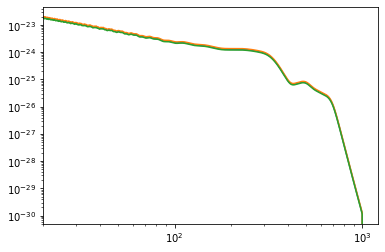

In [51]:
plt.loglog(f, abs(signal["H1"]))
plt.loglog(f, abs(signal["L1"]))
plt.loglog(f, abs(signal["V1"]))
plt.xlim(20,)

In [52]:
integrand = {}
integrand["H1"] = abs(signal["H1"])**2/H1_psd
integrand["L1"] = abs(signal["L1"])**2/L1_psd
integrand["V1"] = abs(signal["V1"])**2/V1_psd

In [53]:
snr_H1 = np.sqrt(4*np.sum(integrand["H1"])*df)
snr_L1 = np.sqrt(4*np.sum(integrand["L1"])*df)
snr_V1 = np.sqrt(4*np.sum(integrand["V1"])*df)
snr_H1, snr_L1, snr_V1

(6.711645805317446, 10.60528543662262, 2.751120661597599)

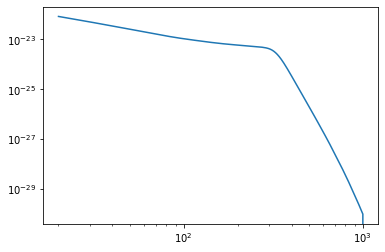

In [54]:
plt.loglog(f, abs(h_intrinsic["22"]))

In [16]:
def bayestarhm_source_model(intrinsic_signal, inclination, distance, ra, dec, psi, geocent_time, det, kwargs):
    
    #evaluates only extrinsic part of the waveform
    #Intrinsic part of the signal of every mode should be provided as a dictionary  
    kappa, f_modulus = antenna_pattern_eff(ra, dec, psi, geocent_time, det)
    cos_kappa = np.cos(kappa)
    sin_kappa = np.sin(kappa)
    
    signal = 0.0
    
    for mode in kwargs["modes"]:
        l = int(mode[0])
        m = int(mode[1])
        C_lm, D_lm = spher_harms_plus_cross_factors(inclination, 0.0, l, m)
        signal += (C_lm*cos_kappa -1j*D_lm*sin_kappa)*intrinsic_signal[mode]
            
    return signal*f_modulus

In [ ]:
#*(mle["geocent_time"]-1 <= params_vec[5] and params_vec[5] <=mle["geocent_time"]-1)

In [17]:
def log_bayestarhm_likelihood(params_vec):
    
    waveform_kwargs = {}
    waveform_kwargs["modes"] = ["22", "33", "44"]
    frequency_array = f
    log_likelihood = 0.0
    #print(params_vec)
    if (-1 <= np.cos(params_vec[0]) and np.cos(params_vec[0]) <= 1)*(300 <= params_vec[1] and params_vec[1] < 800 )*(0 <= params_vec[2] and params_vec[2] <=2*np.pi)*(-1 <= np.sin(params_vec[3]) and np.sin(params_vec[3]) <=1)*(0 <= params_vec[4] and params_vec[4] <=2*np.pi)== 1:

        for det in detectors:
            #print(params_vec[0])
            model = bayestarhm_source_model(h_intrinsic, params_vec[0], params_vec[1], \
                                         params_vec[2], params_vec[3], params_vec[4], \
                                         mle["geocent_time"], det, waveform_kwargs)
            #print(model)
            likelihood_integrand = abs(signal[det] - model)**2
            #print(likelihood_integrand)
            psd = eval('%s_psd'%(det))
            log_likelihood += -2*np.trapz(likelihood_integrand/psd, frequency_array)
            #print("inclination = %f, distance = %f, coa_phase = %f, kappa = %f, log_L = %f"%(params_vec[0],params_vec[1], params_vec[2],params_vec[3], log_likelihood))
        return log_likelihood
    else:
        return -np.inf

In [155]:
log_bayestarhm_likelihood(guess_value)

0.0

In [156]:
mle["geocent_time"]

1186741861.0

In [157]:
n_walkers = 50
ndim = 5
burnin_steps = 500
steps = 100000
guess_value = np.array([np.pi/4,600, mle["ra"], mle["dec"], mle["psi"]])

In [158]:
p0_zero = np.ones([n_walkers,ndim])*guess_value
p0 = p0_zero+np.array([np.random.rand(ndim) for i in range(n_walkers)])

In [ ]:
t0 = time.time()
sampler = emcee.EnsembleSampler(n_walkers,ndim,log_bayestarhm_likelihood)
p1,lnpos1,rs1 = sampler.run_mcmc(p0,burnin_steps)
sampler.reset()
sampler.run_mcmc(p1,steps)
tf = time.time()
print("Time taken in running Emcee sampler with %d walkers and %d steps = %f"%(n_walkers, steps, (tf-t0)))

In [124]:
#np.save("lnp_w-%d_steps-%d_bsteps-%d_zerolag.npy"%(n_walkers,steps,burnin_steps),sampler.flatchain)

In [125]:
sampler.flatchain

array([[ 1.67118248e+00,  6.00886848e+02,  1.06727269e+00,
        -4.83238744e-01,  9.94496784e-01,  1.18674186e+09],
       [ 1.67118248e+00,  6.00886848e+02,  1.06727269e+00,
        -4.83238744e-01,  9.94496784e-01,  1.18674186e+09],
       [ 1.67118248e+00,  6.00886848e+02,  1.06727269e+00,
        -4.83238744e-01,  9.94496784e-01,  1.18674186e+09],
       ...,
       [ 1.10525868e+00,  6.00829262e+02,  1.16862887e+00,
        -5.85265397e-01,  1.22813757e-01,  1.18674186e+09],
       [ 1.10525868e+00,  6.00829262e+02,  1.16862887e+00,
        -5.85265397e-01,  1.22813757e-01,  1.18674186e+09],
       [ 1.10525868e+00,  6.00829262e+02,  1.16862887e+00,
        -5.85265397e-01,  1.22813757e-01,  1.18674186e+09]])

In [126]:
len(sampler.flatchain[:,0])

5000000

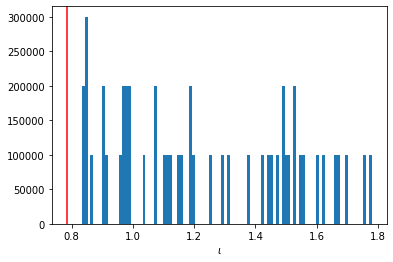

In [127]:
plt.hist(sampler.flatchain[:,0], bins=100)
plt.axvline(x=mle["theta_jn"], c='r')
plt.xlabel("$\iota$")
plt.show()

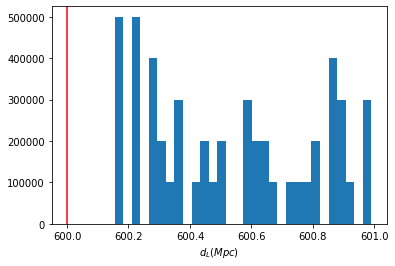

In [117]:
plt.hist(sampler.flatchain[:,1], bins=30)
plt.axvline(x=mle["distance"], c='r')
plt.xlabel("$d_L (Mpc)$")
plt.show()

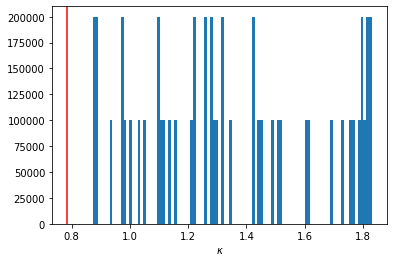

In [118]:
plt.hist(sampler.flatchain[:,2], bins=100)
plt.axvline(x=mle["kappa"], c='r')
#plt.axvline(x=mle["kappa"]+np.pi/2, c='g')
plt.xlabel("$\kappa$")
plt.show()

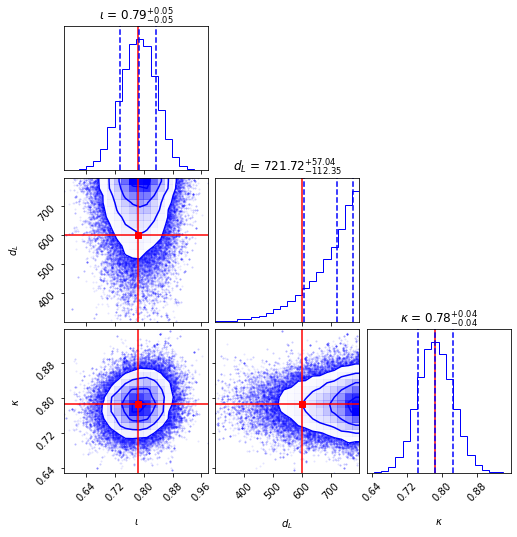

In [127]:
figure = corner.corner(sampler.flatchain, labels=[r"$\iota$", r"$d_L$",  r"$\kappa$"],
                      show_titles=True, color='b', quantiles=[0.16, 0.5, 0.84], truths=[np.pi/4., 600, np.pi/4], truth_color='r')

In [19]:
data = np.load("/home/mukesh/Academics/Bayestar/scripts/lnp_w-50_steps-100000_bsteps-1000_zerolag.npy")

In [20]:
iota = data[:,0]
d = data[:,1]
phic = data[:,2]
kappa1 = data[:,3]

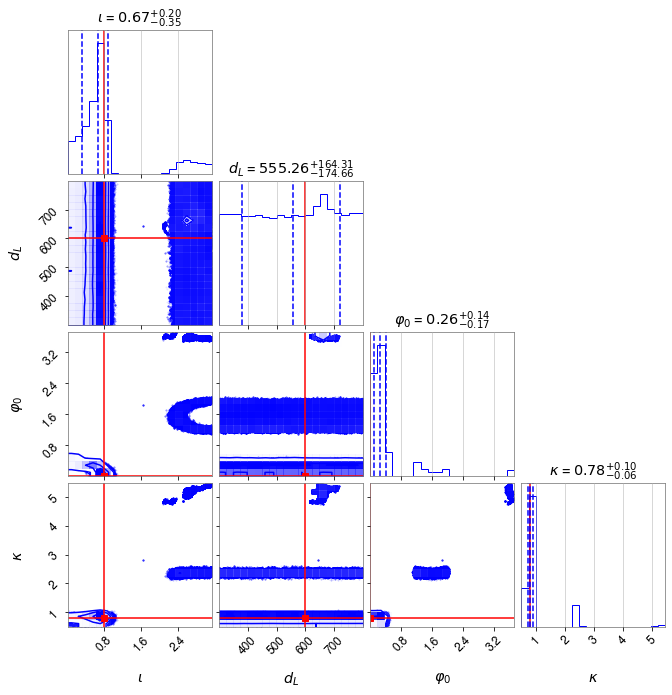

In [198]:
figure = corner.corner(data, labels=[r"$\iota$", r"$d_L$", r"$\varphi_0$", r"$\kappa$"],
                      show_titles=True, color='b', quantiles=[0.16, 0.5, 0.84], truths=[np.pi/4., 600, 0.0, np.pi/4], truth_color='r')

Text(0.5, 0, '$\\varphi_0$')

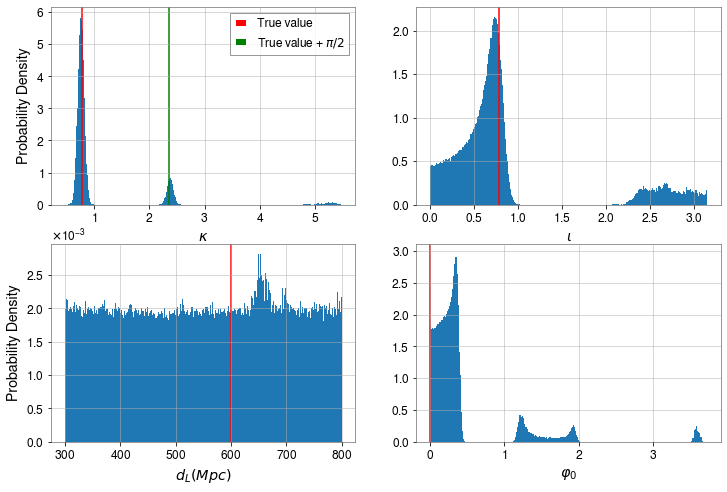

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

ax[0, 0].hist(kappa1, bins=500, density=True)
ax[0, 0].axvline(x=mle["kappa"], c='r', label='True value')
ax[0, 0].axvline(x=mle["kappa"]+np.pi/2, c='g', label='True value + $\pi/2$')
ax[0, 0].set_xlabel("$\kappa$")
ax[0, 0].set_ylabel("Probability Density")
ax[0, 0].legend(loc='best')
#ax[0, 0].set_xlim(0, 3)

ax[0, 1].hist(iota, bins=500, density=True)
ax[0, 1].axvline(x=mle["theta_jn"], c='r')
ax[0, 1].set_xlabel("$\iota$")
#ax[0, 1].set_xlim(0, 3)

ax[1, 0].hist(d, bins=500, density=True)
ax[1, 0].axvline(x=mle["distance"], c='r')
ax[1, 0].set_xlabel("$d_L (Mpc)$")
ax[1, 0].set_ylabel("Probability Density")
#ax[1, 0].set_xlim(0, 3)

ax[1, 1].hist(phic, bins=500, density=True)
ax[1, 1].axvline(x=mle["coa_phase"], c='r')
ax[1, 1].set_xlabel(r"$\varphi_0$")
#ax[0, 1].set_xlim(0, 3)

#fig.savefig("/home/mukesh/Academics/Bayestar/plots/extrinsic_params_4dim_bayestarhm_emcee_sampling.pdf")

## Nested Sampling:

In [21]:
from dynesty import NestedSampler

In [55]:
def log_bayestarhm_like(params_vec):
    
    waveform_kwargs = {}
    waveform_kwargs["modes"] = ["22", "33", "44"]
    frequency_array = f
    log_likelihood = 0.0
    for det in detectors:
            #print(params_vec[0])
            model = bayestarhm_source_model(h_intrinsic, params_vec[0], params_vec[1], \
                                         params_vec[2], params_vec[3], params_vec[4], \
                                         params_vec[5], det, waveform_kwargs)
            #print(model)
            likelihood_integrand = abs(signal[det] - model)**2
            #print(likelihood_integrand)
            psd = eval('%s_psd'%(det))
            log_likelihood += -2*np.trapz(likelihood_integrand/psd, frequency_array)
            #print("inclination = %f, distance = %f, coa_phase = %f, kappa = %f, log_L = %f"%(params_vec[0],params_vec[1], params_vec[2],params_vec[3], log_likelihood))
    return log_likelihood

In [56]:
def prior_transform(u):
    
    x = np.array(u)
    
    #print(u[0])
    
    x[0] = np.arccos(u[0] * 2. - 1.)
    
    x[1] = 500*u[1] + 300
    
    x[2] = 2*np.pi*u[2]
    
    x[3] = np.arcsin(u[3]*2 - 1)
    
    x[4] = 2*np.pi*u[4]
    
    x[5] = mle["geocent_time"] + (u[5]*0.2 - 0.1)
    
    return x

In [57]:
ndim=6
sampler = NestedSampler(log_bayestarhm_like, prior_transform, ndim, nlive=1000, bound='none', sample='rwalk')

In [58]:
sampler.run_nested(dlogz=0.1)

11700it [2:15:14,  1.44it/s, +1000 | bound: 0 | nc: 1 | ncall: 240280 | eff(%):  5.286 | loglstar:   -inf < -0.020 <    inf | logz: -9.391 +/-  0.124 | dlogz:  0.000 >  0.100]


In [59]:
len(sampler.results["samples"][:,0])

12700

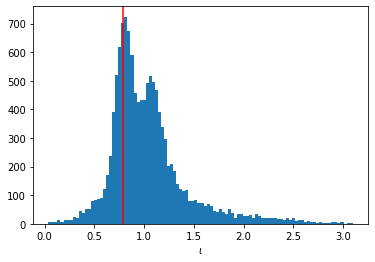

In [60]:
plt.hist(sampler.results["samples"][:,0], bins=100)
plt.axvline(x=mle["theta_jn"], c='r')
plt.xlabel("$\iota$")
plt.show()

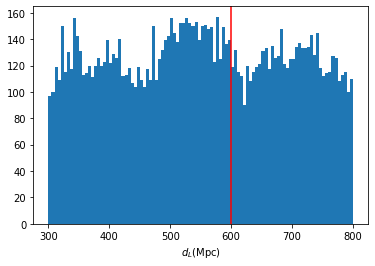

In [61]:
plt.hist(sampler.results["samples"][:,1], bins=100)
plt.axvline(x=mle["distance"], c='r')
plt.xlabel("$d_L$(Mpc)")
plt.show()

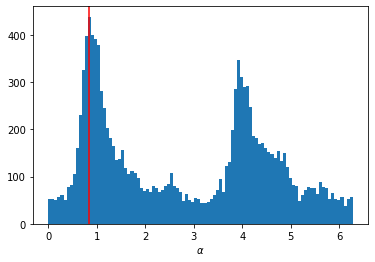

In [62]:
plt.hist(sampler.results["samples"][:,2], bins=100)
plt.axvline(x=mle["ra"], c='r')
plt.xlabel(r"$\alpha$")
plt.show()

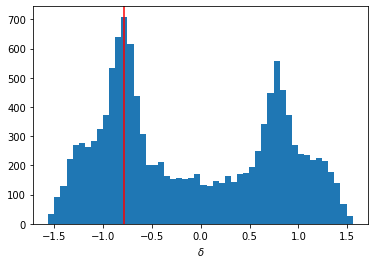

In [63]:
plt.hist(sampler.results["samples"][:,3], bins=50)
plt.axvline(x=mle["dec"], c='r')
plt.xlabel("$\delta$")
plt.show()

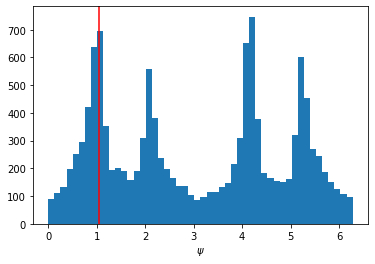

In [64]:
plt.hist(sampler.results["samples"][:,4], bins=50)
plt.axvline(x=mle["psi"], c='r')
plt.xlabel("$\psi$")
plt.show()

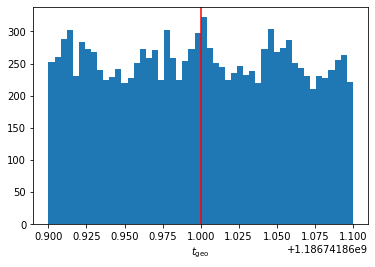

In [65]:
plt.hist(sampler.results["samples"][:,5], bins=50)
plt.axvline(x=mle["geocent_time"], c='r')
plt.xlabel("$t_{\mathrm{geo}}$")
plt.show()

In [88]:
import corner

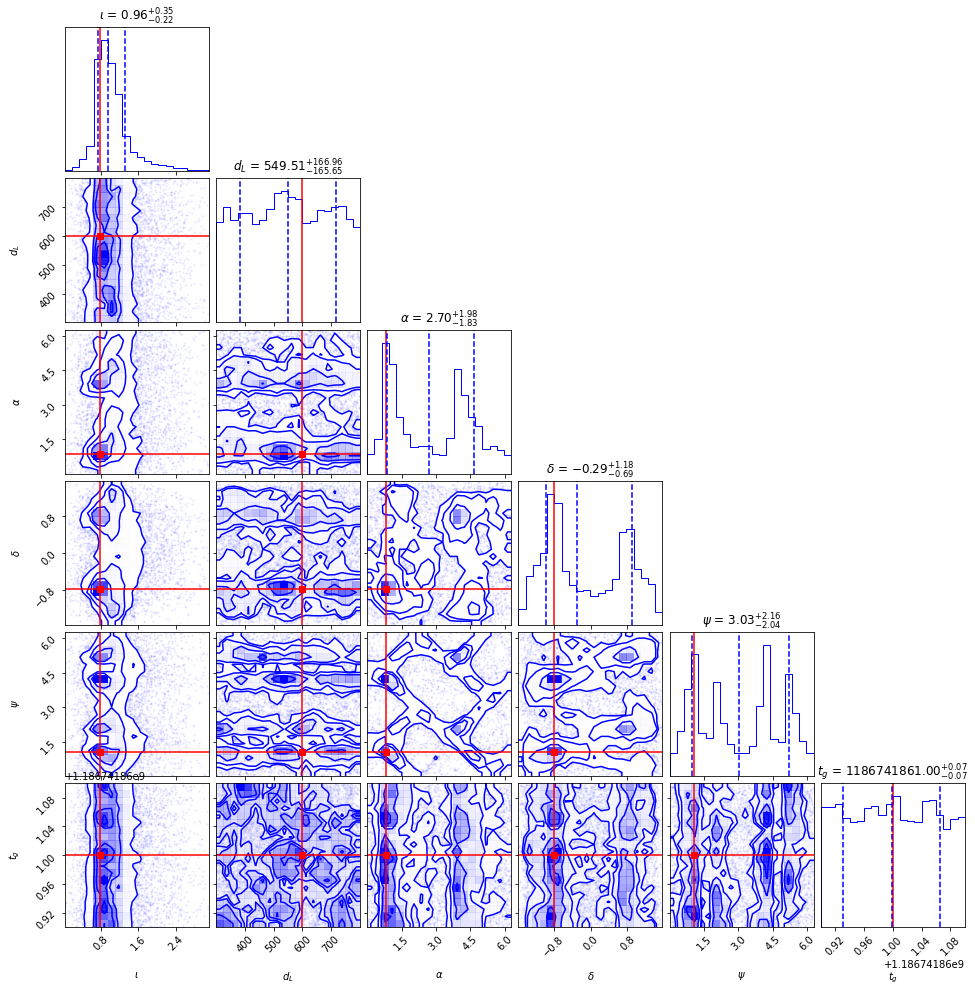

In [69]:
figure = corner.corner(sampler.results["samples"], labels=[r"$\iota$", r"$d_L$", r"$\alpha$", r"$\delta$", r"$\psi$", r"$t_g$"],
                      show_titles=True, color='b', quantiles=[0.16, 0.5, 0.84], truths=[np.pi/4., 600, mle["ra"], mle["dec"], mle["psi"], mle["geocent_time"]], truth_color='r')

In [72]:
import pandas as pd

In [74]:
sampler.results

         nlive: 1000
         niter: 11700
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 5.285500249708673
       samples: array([[ 2.32252050e-01,  5.70829398e+02,  6.13701933e+00,
         6.83758992e-01,  2.25625043e+00,  1.18674186e+09],
       [ 2.93206520e+00,  7.66011046e+02,  1.29779442e-01,
         8.48855356e-01,  5.31283428e+00,  1.18674186e+09],
       [ 3.07110854e+00,  3.28035174e+02,  3.62008058e-01,
         7.15797464e-01,  3.60514529e+00,  1.18674186e+09],
       ...,
       [ 7.72034250e-01,  5.14542047e+02,  3.95921694e+00,
         7.78066502e-01,  5.21982542e+00,  1.18674186e+09],
       [ 7.74076238e-01,  6.79939491e+02,  7.90566314e-01,
        -7.76803877e-01,  1.07276955e+00,  1.18674186e+09],
       [ 7.90429025e-01,  7.99722404e+02,  8.68800005e-01,
        -7.95621722e-01,  1.02193438e+00,  1.18674186e+09]])
    samples_id: array([215, 456, 330, ..., 728, 667, 900])
    samples_it: array([    0,     0,     0, ..., 11276,  8108, 11185], dty

In [77]:
dataframe = pd.DataFrame(sampler.results["samples"])

In [83]:
dataframe.to_csv("nested_sampling_run_iota_dL_ra_dec_psi_geocent_time_nlive_1000.dat", sep=" ", header=["theta_jn", "luminosity_distance", "ra", "dec", "psi", "geocent_time"], index=False)

In [81]:
dataframe

0           1         2         3         4             5
0      0.232252  570.829398  6.137019  0.683759  2.256250  1.186742e+09
1      2.932065  766.011046  0.129779  0.848855  5.312834  1.186742e+09
2      3.071109  328.035174  0.362008  0.715797  3.605145  1.186742e+09
3      0.317370  561.495880  2.964579 -0.321981  0.474368  1.186742e+09
4      0.319712  301.180485  5.781272  0.915849  2.074061  1.186742e+09
...         ...         ...       ...       ...       ...           ...
12695  0.800376  375.929490  3.978310  0.808047  5.237037  1.186742e+09
12696  0.795066  692.341995  0.829546 -0.809818  1.054149  1.186742e+09
12697  0.772034  514.542047  3.959217  0.778067  5.219825  1.186742e+09
12698  0.774076  679.939491  0.790566 -0.776804  1.072770  1.186742e+09
12699  0.790429  799.722404  0.868800 -0.795622  1.021934  1.186742e+09

[12700 rows x 6 columns]

In [89]:
pd.read_csv?